In [1]:
import pytorch_lightning as pl
from models import *
from data.data_classes import *

In [2]:
save_filepath = "./plots/hand_plot3.pdf"

In [3]:
batch_size = 4
num_ctx_frames=1
num_tgt_frames=9
action_types = "flipped_jumpingjack"

weizmann = WeizmannDataModule(batch_size, 
                              num_ctx_frames, num_tgt_frames,
                              action_types=action_types)

weizmann.setup()

val_dl = weizmann.val_dataloader()
val_ctx_frames, val_tgt_frames = next(iter(val_dl))                                                      

### 3DConvNet

In [4]:
# model = ThreeDConv_1to9()
# model = model.load_from_checkpoint("./logs/ThreeDConv_1to9/experiment1/checkpoints/epoch=99-step=900.ckpt")

### SimVP

In [5]:
# # Experiment 3 (mse loss)
# hid_s=64
# hid_t=256
# N_s=4
# N_t=8
# kernel_sizes=[3,5,7,11]
# groups=4

# channels = 3
# height = 144
# width = 180
# input_shape = (channels, num_ctx_frames, height, width)

# model = SimVP_1to9(input_shape=input_shape, 
#                    hid_s=hid_s, hid_t=hid_t, 
#                    N_s=N_s, N_t=N_t,
#                    kernel_sizes=kernel_sizes, 
#                    groups=groups)
# model = model.load_from_checkpoint("./logs/SimVP_1to9/experiment3/checkpoints/epoch=99-step=900.ckpt")

# # Experiment 4 (mse loss)
# model = SimVP_1to9(input_shape=input_shape, 
#                    hid_s=hid_s, hid_t=hid_t, 
#                    N_s=N_s, N_t=N_t,
#                    kernel_sizes=kernel_sizes, 
#                    groups=groups)
# model = model.load_from_checkpoint("./logs/SimVP_1to9/experiment4/checkpoints/epoch=99-step=900.ckpt")

### PredRNN

### Predicted Frames Set 1

In [6]:
# model = ThreeDConv_1to9()
# model = model.load_from_checkpoint("./logs/ThreeDConv_1to9/experiment1/checkpoints/epoch=99-step=900.ckpt")

In [7]:
# model.eval()
# model1_pred_frames = torch.zeros_like(val_tgt_frames)

# for i in range(9):
#     if i == 0:
#         model1_pred_frames[:, :, i] = model(val_ctx_frames).squeeze()
#     else:
#         model1_pred_frames[:, :, i] = model(model1_pred_frames[:, :, i-1:i]).squeeze()

# torch.save(model1_pred_frames, "./plots/1-9-3dconv.pt")
# model1_pred_frames.shape

In [8]:
model1_pred_frames = torch.load("./plots/1-9-3dconv.pt")

### Predicted Frames Set 2

In [9]:
# hid_s=64
# hid_t=256
# N_s=4
# N_t=8
# kernel_sizes=[3,5,7,11]
# groups=4

# channels = 3
# height = 144
# width = 180
# input_shape = (channels, num_ctx_frames, height, width)

# model = SimVP_1to9(input_shape=input_shape, 
#                    hid_s=hid_s, hid_t=hid_t, 
#                    N_s=N_s, N_t=N_t,
#                    kernel_sizes=kernel_sizes, 
#                    groups=groups)
# model = model.load_from_checkpoint("./logs/SimVP_1to9/experiment3/checkpoints/epoch=99-step=900.ckpt")

In [10]:
# model.eval()
# model2_pred_frames = torch.zeros_like(val_tgt_frames)

# for i in range(9):
#     if i == 0:
#         model2_pred_frames[:, :, i] = model(val_ctx_frames).squeeze()
#     else:
#         model2_pred_frames[:, :, i] = model(model2_pred_frames[:, :, i-1:i]).squeeze()

# torch.save(model2_pred_frames, "./plots/1-9-simvp-mse.pt")
# model2_pred_frames.shape

In [11]:
model2_pred_frames = torch.load("./plots/1-9-simvp-mse.pt")

### Predicted Frames Set 3

In [12]:
# Experiment 4 (filtered; mse)
input_channels=3
num_hidden=[64, 64, 64]
kernel_size=5
stride=1
learning_rate=1e-3

model = PredRNN(input_channels=input_channels,
                num_hidden=num_hidden,
                num_ctx_frames=num_ctx_frames,
                num_tgt_frames=num_tgt_frames,
                kernel_size=kernel_size,
                stride=stride)
model = model.load_from_checkpoint("./logs/PredRNN/experiment4/checkpoints/epoch=99-step=900.ckpt")

In [13]:
height = 144
width = 180

model3_pred_frames = torch.zeros(batch_size, 3, 10, height, width)
model3_pred_frames[:, :, 0:1] = val_ctx_frames

model.eval()
for i in range(1, 10):
    input = model3_pred_frames[:, :, i-1:i].repeat(1, 1, 2, 1, 1)
    model3_pred_frames[:, :, i:i+1] = model(input)

torch.save(model3_pred_frames, "./plots/1-9-pred.pt")
model3_pred_frames.shape

torch.Size([4, 3, 10, 144, 180])

### Plotting

In [14]:
def make_ten_frame_thesis_plot(ctx_frame, frame_sets, names, plot_width, plot_height):
    num_ctx_frames= 1
    num_tgt_frames = 9

    def show_frames(frames, ax, row_label):
        ax[0].imshow(ctx_frame)
        ax[0].set_ylabel(row_label)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel("t=1")
        ax[0].xaxis.set_label_coords(.52, 1.15)

        for i, frame in enumerate(frames):
            ax[i+num_ctx_frames].imshow(frame)
            ax[i+num_ctx_frames].set_xticks([])
            ax[i+num_ctx_frames].set_yticks([])
            ax[i+num_ctx_frames].set_xlabel(f"t={2+i}")
            ax[i+num_ctx_frames].xaxis.set_label_coords(.52, 1.15)


    fig, ax = plt.subplots(len(frame_sets), 10,
                               figsize = (plot_width, plot_height))

    for i, frames in enumerate(frame_sets):
        frames = frames.squeeze().permute(1, 2, 3, 0).cpu().detach().numpy()
        show_frames(frames, ax[i], names[i])

    fig.set_facecolor("white")
    plt.savefig(save_filepath)
    return fig

torch.Size([3, 9, 144, 180])
torch.Size([3, 9, 144, 180])
torch.Size([3, 9, 144, 180])
torch.Size([3, 9, 144, 180])


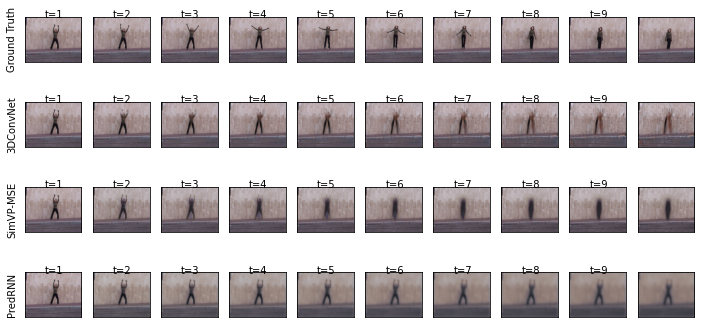

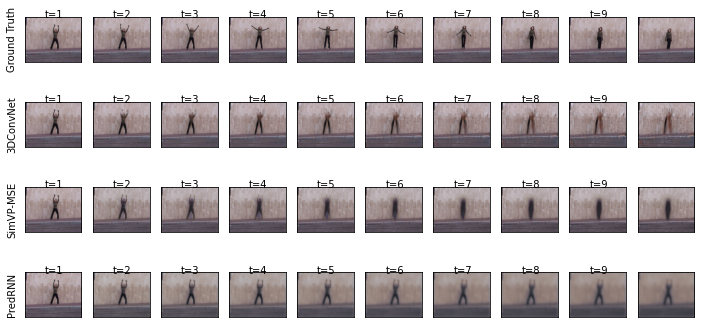

In [15]:
index = 0
plot_width = 12
plot_height = 6

ctx_frame = val_ctx_frames[index].squeeze().permute(1, 2, 0).detach().numpy()
frame_sets = [val_tgt_frames[index],
              model1_pred_frames[index],
              model2_pred_frames[index],
              model3_pred_frames[index, :, 1:]]

names = ["Ground Truth", "3DConvNet", "SimVP", "PredRNN"]               
make_ten_frame_thesis_plot(ctx_frame, frame_sets, 
                           names, plot_width, plot_height)